In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import scipy.optimize as opt
from astropy.io import fits

In [2]:
def fittestdata_DN(tramp, order2):
    coefs = [0.0] * (order2 +1)
    expected_rate = 0
    inramp = 1.0*tramp[tramp < 58000]
    num_samples = inramp.size
    first_fit_order = 3
    if num_samples > order2 + 3:
        time = np.array(list(range(num_samples)), dtype=np.float64)
        solution = np.polynomial.polynomial.polyfit(time, inramp, first_fit_order)
        expected_rate = solution[1]
        expected_DN = expected_rate * time + inramp[0]
    # now get the ratio between the expected DN and the actual DN. 
    # This is the correction factor.
        correction_factor = expected_DN/inramp
    #solve for the correction factor as a function of observed DN
        if np.sum(np.isfinite(correction_factor)) == correction_factor.size:
              coefs = np.polynomial.polynomial.polyfit(inramp, correction_factor, order2)
    return coefs, expected_rate

In [3]:
def correct_ramp_DN(inramp, coefs):
    num_samples = inramp.size
    cor_factor = poly.polyval(inramp, coefs)
    new_rate = np.zeros(num_samples-1, dtype=np.float64)
    corrected_ramp = cor_factor * inramp
    for i in range(1,num_samples):
        new_rate[i-1] = corrected_ramp[i] - corrected_ramp[i-1]
    return new_rate, corrected_ramp

In [4]:
def fitcalimage(calimage, model, order):
    image_shape = calimage.shape
    num_frames = image_shape[0]
    out_parameters = np.zeros(shape =(order + 1, image_shape[1], image_shape[2] ), dtype=np.float64)
    countrateat0DN = np.zeros(shape =(image_shape[1], image_shape[2] ), dtype=np.float64)
    for i in range(image_shape[1]):
        for j in range(image_shape[2]):
            out_parameters[:, i, j], countrateat0DN[i, j] = model(calimage[3:-1, i, j], order)
   #         print(out_parameters[:, i, j],countrateat0DN[i, j])
        if  i//50 * 50 == i:
            print('finished row ',i, out_parameters[:, i, 10],countrateat0DN[i, 170])
    return out_parameters, countrateat0DN

In [5]:
def applynlimage(inramp, correctfunc, solution_image):
    image_shape = inramp.shape
    num_frames = image_shape[0]
    out_ramp = np.zeros_like(inramp, dtype=np.float64)
    new_rate = np.zeros(shape=(num_frames-1, image_shape[1], image_shape[2]), dtype=np.float64)
    for i in range(image_shape[1]):
        for j in range(image_shape[2]):
            new_rate[:, i, j], out_ramp[:, i, j] = correctfunc(1.0*inramp[:, i, j], solution_image[:, i, j])
        if  i//50 * 50 == i:
            print('finished row ',i)
    return out_ramp, new_rate

In [7]:
def find_med_normalized_rate(normalized_rate, inramp, countrateat0DN):
    saturation_level = 58000
    norm_shape = normalized_rate.shape
    med_normalized_rate = np.zeros(norm_shape[0], dtype=np.float64)
    out_cube = np.zeros_like(normalized_rate)
    for i in range(norm_shape[0]):
        normalized_plane = normalized_rate[i,:,:]
        normalized_plane[inramp[i,:,:] > 58000] = np.nan
        normalized_plane[countrateat0DN < 600] = np.nan
        if np.sum(np.isfinite(normalized_plane)) > 10000:
            med_normalized_rate[i] = np.median(
                normalized_plane[np.isfinite(normalized_plane)])            
    return med_normalized_rate[med_normalized_rate > 0]

In [8]:
calimage=fits.getdata('M105_00_000.fits') #CV3 F770W flat from Jane

In [9]:
outsolutionDN, countrateat0DN_DN = fitcalimage(calimage, fittestdata_DN, 4)
new_ramp_DN, new_rate_DN = applynlimage(calimage, correct_ramp_DN ,outsolutionDN)


finished row  0 [ 1.04957448e+00 -7.29936824e-06  3.45241375e-10 -5.68570324e-15
  4.03744664e-20] 769.1006730409728


/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


finished row  50 [ 1.04754950e+00 -7.13871912e-06  3.43303216e-10 -5.92126371e-15
  4.12309429e-20] 552.5138040210334
finished row  100 [ 1.02510655e+00 -3.95149782e-06  1.87185499e-10 -2.67841710e-15
  1.81314370e-20] 580.6651706816072
finished row  150 [ 1.03818699e+00 -5.65638985e-06  2.63706521e-10 -4.17305071e-15
  2.78526994e-20] 619.6191071816091
finished row  200 [ 9.99191525e-01 -6.04729286e-07  3.84854633e-11  1.17655627e-16
 -9.26295306e-22] 677.1547071019359
finished row  250 [ 1.03549545e+00 -5.28925011e-06  2.42821129e-10 -4.03655388e-15
  3.00198600e-20] 729.4571583636091
finished row  300 [ 1.06168757e+00 -8.56749177e-06  3.83612317e-10 -6.28518345e-15
  4.19790224e-20] 799.3815628580438
finished row  350 [ 1.02697118e+00 -4.25609080e-06  1.96082899e-10 -2.74998666e-15
  1.82464946e-20] 847.8342136730429
finished row  400 [ 1.06881899e+00 -9.49213039e-06  4.23663113e-10 -7.26328835e-15
  4.98362821e-20] 879.9336432828325
finished row  450 [ 1.09557803e+00 -1.28238372e-0

In [10]:
hdu = fits.PrimaryHDU(new_rate_DN)
hdu.writeto('newrateDN.fits', overwrite=True)
normalized_rateDN = new_rate_DN/countrateat0DN_DN
hdu = fits.PrimaryHDU(normalized_rateDN)
hdu.writeto('normalizedrateDN.fits',overwrite=True)


/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
med_norm_rate_DN = find_med_normalized_rate(normalized_rateDN[:-1,:,:], calimage,countrateat0DN_DN)

0.0013456728600408855

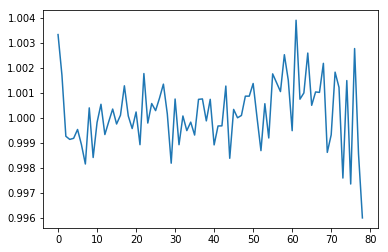

In [12]:
plt.plot(med_norm_rate_DN[4:])
np.std(med_norm_rate_DN[4:])

<h2>Now try to correct the 2nd integration using the cal parameters from the 1st integration</h2>

In [13]:
correct_image1=fits.getdata('M105_00_000.fits')

In [15]:
cor_ramp_DN, cor_rate_DN = applynlimage(correct_image1, correct_ramp_DN ,outsolutionDN)

finished row  0
finished row  50
finished row  100
finished row  150
finished row  200
finished row  250
finished row  300
finished row  350
finished row  400
finished row  450
finished row  500
finished row  550
finished row  600
finished row  650
finished row  700
finished row  750
finished row  800
finished row  850
finished row  900
finished row  950
finished row  1000
finished row  1050
finished row  1100
finished row  1150
finished row  1200
finished row  1250


In [16]:
hdu = fits.PrimaryHDU(cor_ramp_DN)
hdu.writeto('corrampDN.fits', overwrite=True)
hdu = fits.PrimaryHDU(cor_rate_DN)
hdu.writeto('corrateDN.fits', overwrite=True)

/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/mregan/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.0013456728600408855

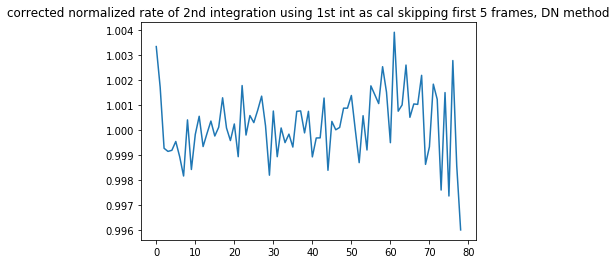

In [17]:
normalized_rate_corDN = cor_rate_DN/countrateat0DN_DN
hdu = fits.PrimaryHDU(normalized_rate_corDN)
hdu.writeto('normalizedratecorDN.fits',overwrite=True)
med_norm_rate_corDN = find_med_normalized_rate(normalized_rate_corDN[:-1,:,:], calimage,countrateat0DN_DN)
plt.plot(med_norm_rate_corDN[4:])
plt.title("corrected normalized rate of 2nd integration using 1st int as cal skipping first 5 frames, DN method")
np.std(med_norm_rate_corDN[4:])